In [1]:
import torch
import torch.backends.cudnn as cudnn
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import pandas as pd
import os
from tqdm import tqdm
from clearml import Task, Logger
from datetime import datetime
from datasets import load_from_disk, load_dataset
import random
import evaluate
from transformers import VisionEncoderDecoderModel
from textwrap import wrap
import matplotlib.pyplot as plt


%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=
%env CLEARML_API_SECRET_KEY=

cudnn.benchmark = True
plt.ion()  # interactive mode

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=
env: CLEARML_API_SECRET_KEY=
Using cuda device


WikiArt New Captions (load from disk)

In [ ]:
wikiart_dataset = load_from_disk("dataset_folder_name")

WikiArt New Captions (load from HUB)

In [ ]:
wikiart_dataset = load_dataset("AterMors/wikiart_recaption")

In [3]:
#Load only half of the dataset (since it improve training speed without significant loss of quality )
wikiart_dataset = wikiart_dataset["train"].train_test_split(test_size = 0.5)
wikiart_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'text', 'index'],
        num_rows: 40677
    })
    test: Dataset({
        features: ['image', 'text', 'index'],
        num_rows: 40678
    })
})

Random Samples from Dataset

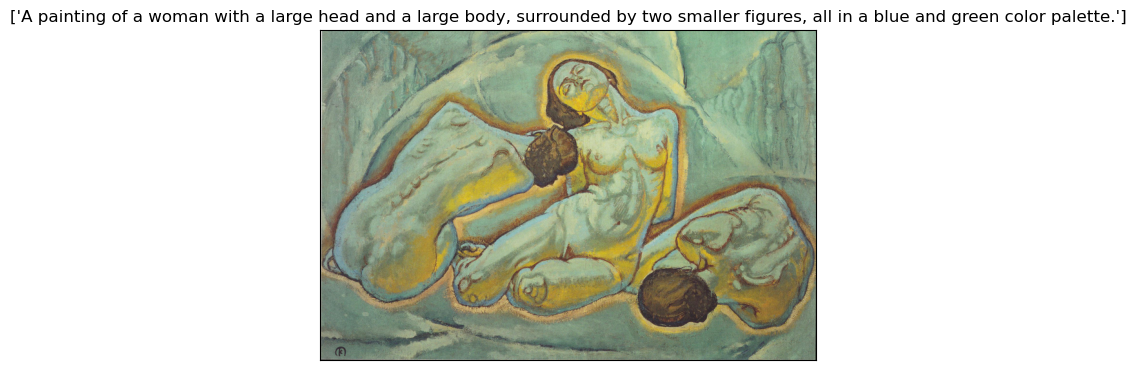

In [13]:
index = random.randint(0, len(wikiart_dataset["train"]))
image = wikiart_dataset["train"][index]["image"]
label = wikiart_dataset["train"][index]["text"]
plt.imshow(np.array(image))
plt.title(label)
plt.xticks([])
plt.yticks([])
plt.show()

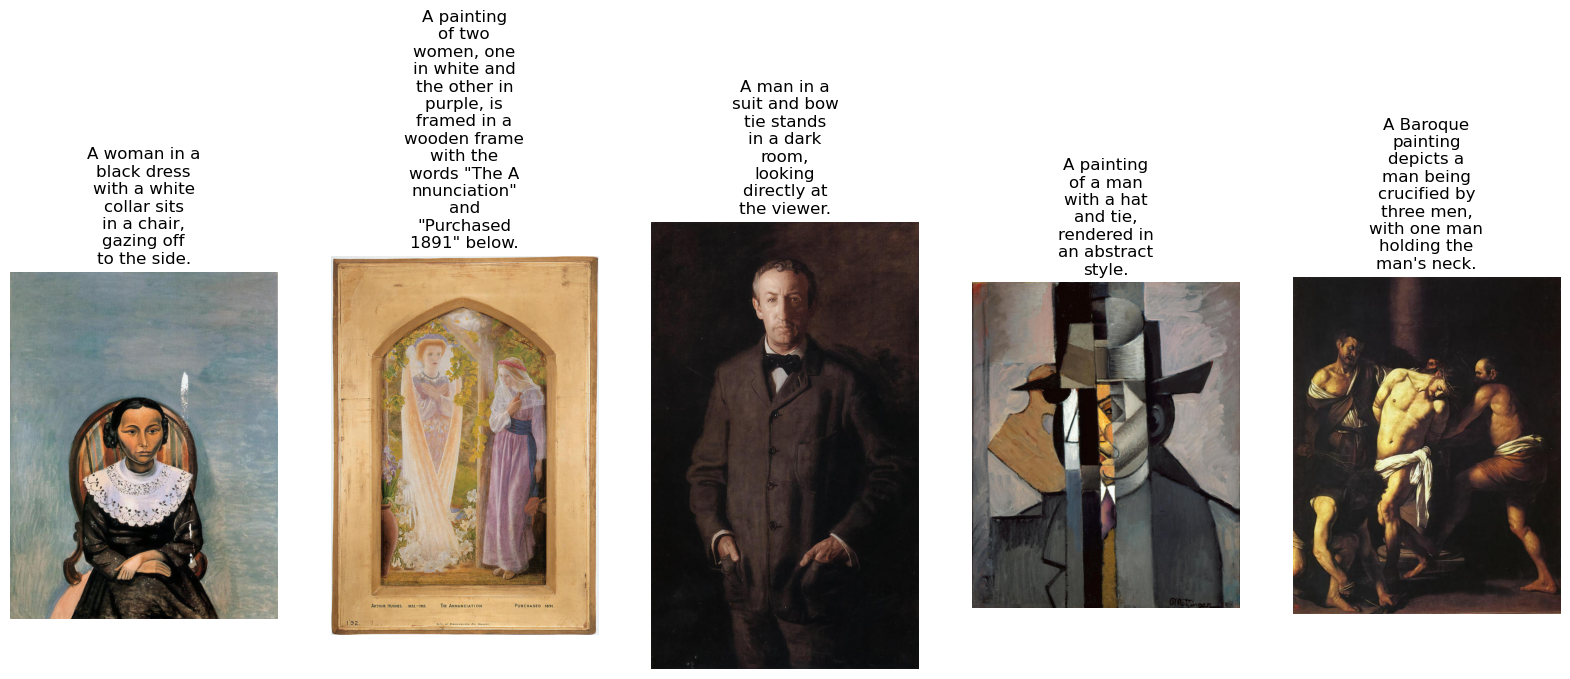

In [12]:
def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")


rand_indexes = np.random.randint(0, len(wikiart_dataset["train"]), 5)
sample_images_to_visualize = [
    np.array(wikiart_dataset["train"][int(i)]["image"]) for i in rand_indexes
]
sample_captions = [wikiart_dataset["train"][int(i)]["text"][0] for i in rand_indexes]
plot_images(sample_images_to_visualize, sample_captions)

Train-Val-Test Split

In [3]:
wikiart_dataset = wikiart_dataset["train"].train_test_split(test_size=0.2)
test_valid_split = wikiart_dataset["test"].train_test_split(test_size=0.2)

wikiart_dataset["validation"] = test_valid_split["train"]
wikiart_dataset["test"] = test_valid_split["test"]

wikiart_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'text', 'index'],
        num_rows: 65084
    })
    test: Dataset({
        features: ['image', 'text', 'index'],
        num_rows: 3255
    })
    validation: Dataset({
        features: ['image', 'text', 'index'],
        num_rows: 13016
    })
})

Base Models Selection and Tokenizer and ImageProcessor generation

In [4]:
from transformers import (
    AutoTokenizer,
    AutoImageProcessor,
    BertTokenizer,
    Swinv2Config,
    BertConfig,
    GPT2TokenizerFast,
    GPT2Config,
    BartTokenizer,
    BartConfig,
    RobertaTokenizerFast,
    RobertaConfig,
    AutoConfig,
)

# Image Encoders Choices

# image_encoder = "google/vit-base-patch16-224"
image_encoder = "microsoft/swinv2-base-patch4-window12to16-192to256-22kto1k-ft"
# image_encoder = "microsoft/beit-base-patch16-224-pt22k-ft22k"
# image_encoder = "facebook/deit-base-distilled-patch16-384"

image_encoder_config = Swinv2Config.from_pretrained(image_encoder)
feature_extractor = AutoImageProcessor.from_pretrained(image_encoder)


# Text Encoders Choices

# BERT
# text_decoder = "bert-base-uncased"
# tokenizer = BertTokenizer.from_pretrained(text_decoder)
# text_decoder_config = BertConfig.from_pretrained(text_decoder)

# BART
# text_decoder = "facebook/bart-base"
# tokenizer = BartTokenizer.from_pretrained(text_decoder)
# text_decoder_config = BartConfig.from_pretrained(text_decoder)

# ROBERTA
# text_decoder = "FacebookAI/roberta-base"
# tokenizer = RobertaTokenizerFast.from_pretrained(text_decoder)
# text_decoder_config = RobertaConfig.from_pretrained(text_decoder)

# GPT2
text_decoder = "gpt2"
tokenizer = GPT2TokenizerFast.from_pretrained(text_decoder)
text_decoder_config = GPT2Config.from_pretrained(text_decoder)
tokenizer.add_special_tokens({"pad_token": "[PAD]"})


# Universal Setting for functioning with VisionEncoderDecoder
text_decoder_config.is_decoder = True
text_decoder_config.add_cross_attention = True

/home/ater/miniforge3/envs/torch2/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [5]:
#Check on which special tokens are present in the tokenizer
(
    tokenizer.cls_token_id,
    tokenizer.pad_token_id,
    tokenizer.eos_token_id,
    tokenizer.bos_token_id,
)

(None, 50257, 50256, 50256)

Model Construction and Configuration

In [5]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    encoder_pretrained_model_name_or_path=image_encoder,
    decoder_pretrained_model_name_or_path=text_decoder,
    encoder_config=image_encoder_config,
    decoder_config=text_decoder_config,
)


encoder_pretrained = False
decoder_pretrained = False

# Adapt Configuration according to token presents in the corresponding tokenizer
if tokenizer.cls_token_id is not None:
    model.config.decoder_start_token_id = tokenizer.cls_token_id
else:
    model.config.decoder_start_token_id = tokenizer.bos_token_id

if tokenizer.pad_token_id is not None:
    model.config.pad_token_id = tokenizer.pad_token_id
else:
    model.config.pad_token_id = tokenizer.eos_token_id

# Resize token embedding to account for the new token added to GPT2 tokenizer
model.decoder.resize_token_embeddings(len(tokenizer))

model.config.add_cross_attention = True
model.config.max_length = 100
model.config.num_beams = 8
model.config.no_repeat_ngram_size = 3
# model.config.num_beam_groups = 4
# model.config.diversity_penalty = 0.1


learning_rate = 7e-5
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=learning_rate,
    #Added weight decay to prevent overfitting
    weight_decay=1e-6,
)

#Put model on selected device
model = model.to(device)
model

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

VisionEncoderDecoderModel(
  (encoder): Swinv2Model(
    (embeddings): Swinv2Embeddings(
      (patch_embeddings): Swinv2PatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Swinv2Encoder(
      (layers): ModuleList(
        (0): Swinv2Stage(
          (blocks): ModuleList(
            (0-1): 2 x Swinv2Layer(
              (attention): Swinv2Attention(
                (self): Swinv2SelfAttention(
                  (continuous_position_bias_mlp): Sequential(
                    (0): Linear(in_features=2, out_features=512, bias=True)
                    (1): ReLU(inplace=True)
                    (2): Linear(in_features=512, out_features=4, bias=False)
                  )
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features

Native Pytorch Dataset Class for WikiArt

In [6]:
from torch.utils.data import Dataset, DataLoader

#It Specify image processing and tokenization of the dataset inside the class to have it done on the fly when needed
class WikiArtDataset(Dataset):
    def __init__(self, dataset, transform=None, tokenizer=None, max_length=100):
        self.dataset = dataset
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        img = item["image"]
        caption = item["text"][0]
        
        if self.transform:
            img = self.transform.preprocess(img, return_tensors="pt")[
                "pixel_values"
            ].to(device)
            img = img.squeeze(0)
        
        #Specify a padding and truncation strategy for the tokenizer on the max_length specified in the init function
        if self.tokenizer:
            caption = self.tokenizer(
                caption, padding="max_length", max_length=self.max_length, truncation=True, return_tensors="pt"
            ).to(device)
            caption["input_ids"] = caption["input_ids"].squeeze(0)
            caption["attention_mask"] = caption["attention_mask"].squeeze(0)

        return img, caption


train_dataset = WikiArtDataset(
    wikiart_dataset["train"],
    transform=feature_extractor,
    tokenizer=tokenizer,
    max_length=90,
)
validation_dataset = WikiArtDataset(
    wikiart_dataset["validation"],
    transform=feature_extractor,
    tokenizer=tokenizer,
    max_length=90,
)
test_dataset = WikiArtDataset(
    wikiart_dataset["test"],
    transform=feature_extractor,
    tokenizer=tokenizer,
    max_length=90,
)

Test of the tokenized captions

In [12]:
index = 0
tokenizer.decode(token_ids = train_dataset[index][1]["input_ids"], attention_mask=train_dataset[index][1]["attention_mask"])

'A drawing of a field with trees and clouds in the sky.[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]'

Native Pytorch DataLoaders

In [7]:
#The batch size has been set to 8 for limitation of the available VRAM
batch_size = 8
data_loaders = {
    "train": DataLoader(train_dataset, shuffle=True, batch_size=batch_size),
    "validation": DataLoader(validation_dataset, shuffle=False, batch_size=batch_size),
    "test": DataLoader(test_dataset, shuffle=False, batch_size=batch_size),
}

dataset_sizes = {
    "train": len(train_dataset),
    "validation": len(validation_dataset),
    "test": len(test_dataset),
}

Custom Train Script

In [8]:
#Custom Train Function adapted to the VisionEncoderDecoderModel
def train_model(model, optimizer, criterion=None, logger=None, num_epochs=5, scheduler=None):
    since = time.time()

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(
            tempdir, f"best_model_params_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pt"
        )

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = np.inf

        for epoch in range(num_epochs):
            curr_lr = optimizer.param_groups[0]["lr"]
            print(f"Epoch: {epoch + 1}/{num_epochs} ; lr = {curr_lr}")
            print("-" * 10)

            #Logger function to report learning rate if clearML logger is provided+
            if logger is not None:
                logger.report_scalar("Learning Rate", "lr", curr_lr, epoch)

            for phase in ["train", "validation"]:
                if phase == "train":
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0

                pbar = tqdm(data_loaders[phase], desc=f"Phase : {phase}")
                #Specify some accumulation steps to help with training on smaller batch size
                accumulation_steps = 8
                for idx, batch in enumerate(pbar):
                    images = batch[0].to(device)
                    captions = batch[1]

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == "train"):
                        #Necessary as different text_decoder require different configuration of input
                        if model.decoder.config.__class__ is BertConfig:
                            outputs = model(
                                pixel_values=images,
                                decoder_input_ids=captions["input_ids"],
                                decoder_attention_mask=captions["attention_mask"],
                                labels=captions["input_ids"],
                            )
                        else:
                            outputs = model(
                                pixel_values=images, labels=captions["input_ids"]
                            )

                        #Use the default loss function given by VisionEncoderDecoderModel (CrossEntropyLoss)
                        loss = outputs.loss

                        if phase == "train":
                            loss.backward()
                            if idx % accumulation_steps == 0:
                                optimizer.step()

                    running_loss += loss.item() * images.size(0)
                    pbar.set_postfix({"Loss": running_loss / dataset_sizes[phase]})

                #Step the scheduler if it is present
                if phase == "train" and scheduler is not None:
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                #Logger function to report loss if clearML logger is provided
                if logger is not None:
                    if phase == "train":
                        logger.report_scalar("Loss", "train", epoch_loss, epoch)
                    else:
                        logger.report_scalar("Loss", "val", epoch_loss, epoch)

                print(f"{phase} Loss: {epoch_loss:.4f}")

                if phase == "validation" and epoch_loss < best_loss:
                    print("New Best Model Found")
                    best_loss = epoch_loss
                    # torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(
            f"Training complete in {time_elapsed // 3600:.0f}h {(time_elapsed // 60)%60:.0f}m {time_elapsed % 60:.0f}s"
        )
        print(f"Best val loss: {best_loss:.4f}")
        print(f"Final val loss: {epoch_loss:.4f}")

    return model

Training Configuration and Logging

In [9]:
from transformers import (
    get_cosine_schedule_with_warmup,
)

num_epochs = 15
num_training_steps = num_epochs * len(data_loaders["train"])

#Use the cosine scheduler that will start from a learning rate of 0.0 to arrive to the learning rate specified in the optimizer
scheduler = get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=int(num_epochs*0.2), num_training_steps=num_training_steps
)

#Parameters Dictionary to be logged on ClearML experiment tracker
params_dict = {
    "learning_rate": learning_rate,
    "weight_decay": optimizer.param_groups[0]["weight_decay"],
    "optimizer": optimizer.__class__.__name__,
    "scheduler": scheduler.__class__.__name__ if scheduler is not None else "None",
    "base_model": model.__class__.__name__,
    "image_encoder": image_encoder,
    "text_decoder": text_decoder,
    "num_epochs": num_epochs,
    "dataset": train_dataset.__class__.__name__,
    "batch_size": data_loaders["train"].batch_size,
    "text_decoder_num_beams" : model.decoder.config.num_beams,
    "text_decoder_num_beam_groups" : model.config.num_beam_groups,
    "text_decoder_max_length" : model.config.max_length,
}

In [9]:
#Obtain all models configuration to pass to the Logger
encoder_config = {}
decoder_config = model.decoder.config
model_config = model.config

#Remove the id2Label and label2id from a copy of the configuration in order to correctly log it
for i in model.encoder.config.__dict__:
    if i not in ["id2label", "label2id"]:
        encoder_config[i] = model.encoder.config.__dict__[i]

Preprocessing and Inference Function

In [10]:
#Apply the preprocessing of the image_encoder
def preprocess_image(image):
    image = feature_extractor.preprocess(image, return_tensors="pt")["pixel_values"]
    return image

#Generate the caption with the generation configuration specified above
def generate_caption(model, tokenizer, image, max_length=50):
    model.eval()

    image = preprocess_image(image).to(device)
    with torch.no_grad():
        outputs_id = model.generate(
            pixel_values=image,
            max_length=max_length,
            decoder_start_token_id=model.config.decoder_start_token_id,
            bos_token_id=model.config.bos_token_id,
            pad_token_id=model.config.pad_token_id,
            eos_token_id=model.config.eos_token_id if model.config.eos_token_id is not None else model.config.pad_token_id,
            num_beams=model.config.num_beams,
            no_repeat_ngram_size=model.config.no_repeat_ngram_size,
        )

    caption = tokenizer.decode(outputs_id[0], skip_special_tokens=True)

    return caption

Train Call with Experiment Tracking

In [ ]:
import traceback

#Obtain the last util index from the saved models
index = 0
files = os.listdir("models/" + model.__class__.__name__)
for i in files:
    nr = int(i.split("_")[-1])
    if nr > index:
        index = nr
        
nrFiles = len(files)

dataset_type = "-Full" if dataset_sizes["train"] > 40000 else "-Half"

#Initialize the ClearML task with all the necessary parameters
task = Task.init(
    project_name="CulturalHeritageCaptioning",
    task_name=("FineTune_" + model.__class__.__name__ + str(index + 1)),
    task_type=Task.TaskTypes.training,
    #Disable autto logging to obtain more control on the logging
    auto_connect_frameworks={"pytorch":False},
    tags=[
        "Fine-Tune",
        "Image-Captioning",
        model.__class__.__name__,
        model.encoder.__class__.__name__ + "+" + model.decoder.__class__.__name__,
        "VisionEncoderDecoderModel",
        train_dataset.__class__.__name__ + dataset_type,
        "EncoderRetrain" if not encoder_pretrained else "EncoderPretrained",
        "DecoderRetrain" if not decoder_pretrained else "DecoderPretrained",
        "55Continue",
    ],
)
#Log all the parameters and configuration dictionary created before
task.connect(params_dict, name="Params")
task.connect(encoder_config, name="ImageEncoderConfig")
task.connect(decoder_config, name="TextDecoderConfig")
task.connect(model_config, name="Model Config")
#Obtain task logger to log learning rate and loss
logger = task.get_logger()

try:
    #Call the custom training script defined before
    trained_model = train_model(model, optimizer, criterion=None, logger=logger,
                                num_epochs=params_dict["num_epochs"], scheduler=(scheduler if scheduler is not None else None))
    
    #Save on the disk the resulting model
    torch.save(trained_model.state_dict(), "models/" + model.__class__.__name__ + "/" + model.__class__.__name__ + "_" + str(index + 1))
    print("Model Saved")
    
    #Load three different metrics to evaluate the model
    print("Evaluating Model")
    bleu = evaluate.load("bleu")
    rouge = evaluate.load("rouge")
    meteor = evaluate.load("meteor")

    generated_captions = []
    reference_captions = []
        
    #Generate all captions from the test dataset
    for i in tqdm(wikiart_dataset["test"], desc="Generating Captions Test"):
        image = i["image"]
        label = i["text"][0]
        caption = generate_caption(model, tokenizer, image, max_length=100)
        generated_captions.append(caption)
        reference_captions.append(label)
    
    #Specify the predictions and references for the three metrics
    predictions = [gen for gen in generated_captions]
    references = [[ref] for ref in reference_captions]

    #Compute the three different metrics
    bleu_score = bleu.compute(predictions=predictions, references=references)
    rouge_score = rouge.compute(predictions=predictions, references=references)
    meteor_score = meteor.compute(predictions=predictions, references=references)
    
    #Log results on ClearML
    task.connect(bleu_score, name="BLEU Score")
    task.connect(rouge_score, name="ROUGE Score")
    task.connect(meteor_score, name="METEOR Score")

    print(f"BLEU Score: {bleu_score}")
    print(f"ROUGE Score: {rouge_score}")
    print(f"Meteor Score: {meteor_score}")
    
    task.close()
    print("task closed")

except Exception as e:
    print("EXCPETION:")
    traceback.print_exc()
    task.close()

Training Call without experiment tracking

In [ ]:
trained_model = train_model(
    model,
    optimizer,
    criterion=None,
    logger=None,
    num_epochs=params_dict["num_epochs"],
    scheduler=(scheduler if scheduler is not None else None),
)

torch.save(trained_model.state_dict(), "models/" + model.__class__.__name__ + "/" + model.__class__.__name__ + "_" + str(index + 1))
print("Model Saved")

#Load three different metrics to evaluate the model
print("Evaluating Model")
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")
meteor = evaluate.load("meteor")

generated_captions = []
reference_captions = []
    
#Generate all captions from the test dataset
for i in tqdm(wikiart_dataset["test"], desc="Generating Captions Test"):
    image = i["image"]
    label = i["text"][0]
    caption = generate_caption(model, tokenizer, image, max_length=100)
    generated_captions.append(caption)
    reference_captions.append(label)

#Specify the predictions and references for the three metrics
predictions = [gen for gen in generated_captions]
references = [[ref] for ref in reference_captions]

#Compute the three different metrics
bleu_score = bleu.compute(predictions=predictions, references=references)
rouge_score = rouge.compute(predictions=predictions, references=references)
meteor_score = meteor.compute(predictions=predictions, references=references)

print(f"BLEU Score: {bleu_score}")
print(f"ROUGE Score: {rouge_score}")
print(f"Meteor Score: {meteor_score}")


Loading Pretrained Weights

In [13]:
model.load_state_dict(
    torch.load(
        "models/VisionEncoderDecoderModel/VisionEncoderDecoderModel_68",
        map_location=device,
    )
)

<All keys matched successfully>

Save Model to Huggingface Hub

In [ ]:
from transformers import GenerationConfig
from huggingface_hub import HfApi, HfFolder, Repository

generation_config = GenerationConfig(
    max_length=100,
    num_beams=model.config.num_beams,
    no_repeat_ngram_size=model.config.no_repeat_ngram_size,
    pad_token_id=model.config.pad_token_id,
    bos_token_id=model.config.bos_token_id,
    eos_token_id=model.config.eos_token_id,
)

repo = Repository(
    local_dir="models/hub/swin2_gpt2_art_captioning",
    clone_from="AterMors/Swin2-GTP2_art-caption",
)

generation_config.save_pretrained("models/hub/swin2_gpt2_art_captioning")
model.save_pretrained("models/hub/swin2_gpt2_art_captioning")
tokenizer.save_pretrained("models/hub/swin2_gpt2_art_captioning")
feature_extractor.save_pretrained("models/hub/swin2_gpt2_art_captioning")

repo.push_to_hub(commit_message="First Commit")

WIkiArt Inference

Index:  785
Generated Caption: A postcard with three naked women, one holding a net, and the words "Cscola de bellas arts" and "Brasport, Switzerland" written on it.


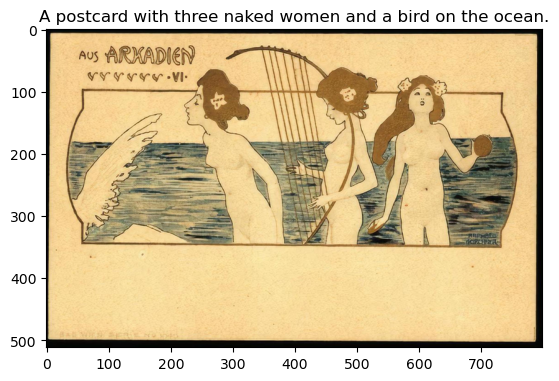

In [26]:
import random

#Generate a caption from a random sample in the test dataset
split = "test"
index = random.randint(0, len(wikiart_dataset[split]))
# index = 3357
print("Index: ", index)
image = wikiart_dataset[split][index]["image"]
caption_truth = wikiart_dataset[split][index]["text"][0]
caption = generate_caption(model, tokenizer, image, max_length=100)
print(f"Generated Caption: {caption}")
plt.imshow(np.array(image))
plt.title(caption_truth)
plt.show()

Test Images (One for each major artistic current)

In [ ]:
import os

files = os.listdir("./test")

sample_images_to_visualize = []
sample_ground_captions = []
sample_generated_captions = []
captions_dict = {}

#Generate and visualize captions for all images in the test folder
for i in tqdm(files, desc="Generating..."):
    image = Image.open(f"./test/{i}")
    caption = generate_caption(model, tokenizer, image, max_length=200)
    print(f"Generated Caption: {caption}")
    image.show()
    sample_images_to_visualize.append(np.array(image))
    sample_generated_captions.append(caption)
    captions_dict[i] = caption
